In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import awkward as ak
import scipy
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl

ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

path_prefix = '/AL/Phd/maxml/'
plotpath = path_prefix+'caloml-atlas/regression/Plots_deadcell/'
modelpath = path_prefix+'caloml-atlas/classifier/Models/'

In [3]:
import sys
sys.path.append(path_prefix+'caloml-atlas/')
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [4]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [8]:
inputpath = path_prefix+'caloml-atlas/inputs/'

truth_branches = ['truthPartPdgId', 'truthPartStatus', 'truthPartBarcode',
                  'truthPartPt', 'truthPartE', 'truthPartMass',
                  'truthPartEta', 'truthPartPhi']
track_branches = ['nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta',
                  'trackPhi', 'trackNumberOfPixelHits',
                  'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors',
                  'trackNumberOfSCTDeadSensors',
                  'trackNumberOfPixelSharedHits',
                  'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles',
                  'trackNumberOfSCTHoles',
                  'trackNumberOfInnermostPixelLayerHits',
                  'trackNumberOfNextToInnermostPixelLayerHits',
                  'trackExpectInnermostPixelLayerHit',
                  'trackExpectNextToInnermostPixelLayerHit',
                  'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers',
                  'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0',
                  'trackEta_PreSamplerB', 'trackPhi_PreSamplerB',
                  'trackEta_PreSamplerE', 'trackPhi_PreSamplerE',
                  'trackEta_EMB1', 'trackPhi_EMB1', 'trackEta_EMB2',
                  'trackPhi_EMB2', 'trackEta_EMB3', 'trackPhi_EMB3',
                  'trackEta_EME1', 'trackPhi_EME1', 'trackEta_EME2',
                  'trackPhi_EME2', 'trackEta_EME3', 'trackPhi_EME3',
                  'trackEta_HEC0', 'trackPhi_HEC0', 'trackEta_HEC1',
                  'trackPhi_HEC1', 'trackEta_HEC2', 'trackPhi_HEC2',
                  'trackEta_HEC3', 'trackPhi_HEC3', 'trackEta_TileBar0',
                  'trackPhi_TileBar0', 'trackEta_TileBar1',
                  'trackPhi_TileBar1', 'trackEta_TileBar2',
                  'trackPhi_TileBar2', 'trackEta_TileGap1',
                  'trackPhi_TileGap1', 'trackEta_TileGap2',
                  'trackPhi_TileGap2', 'trackEta_TileGap3',
                  'trackPhi_TileGap3', 'trackEta_TileExt0',
                  'trackPhi_TileExt0', 'trackEta_TileExt1',
                  'trackPhi_TileExt1', 'trackEta_TileExt2',
                  'trackPhi_TileExt2']
jet_branches = ['AntiKt4EMTopoJetsPt', 'AntiKt4EMTopoJetsEta',
                'AntiKt4EMTopoJetsPhi', 'AntiKt4EMTopoJetsE',
                'AntiKt4LCTopoJetsPt', 'AntiKt4LCTopoJetsEta',
                'AntiKt4LCTopoJetsPhi', 'AntiKt4LCTopoJetsE',
                'AntiKt4TruthJetsPt', 'AntiKt4TruthJetsEta',
                'AntiKt4TruthJetsPhi', 'AntiKt4TruthJetsE',
                'AntiKt4TruthJetsFlavor']
cluster_branches = ['nCluster', 'cluster_E', 'cluster_E_LCCalib',
                    'cluster_Pt', 'cluster_Eta', 'cluster_Phi',
                    'cluster_nCells', 'cluster_ENG_CALIB_TOT',
                    'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT',
                    'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT',
                    'cluster_OOC_WEIGHT', 'cluster_DM_WEIGHT',
                    'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS',
                    'cluster_CENTER_LAMBDA', 'cluster_ISOLATION',
                    'cluster_ENERGY_DigiHSTruth', 'cluster_cell_ID',
                    'cluster_cell_E', 'cluster_hitsTruthIndex',
                    'cluster_hitsTruthE']

geo_branches = [
    'cell_geo_ID', 'cell_geo_sampling', 'cell_geo_eta', 'cell_geo_phi',
    'cell_geo_rPerp', 'cell_geo_deta', 'cell_geo_dphi', 'cell_geo_volume',
    'cell_geo_sigma'
]

In [6]:
def tvt_sets(data, tvt=(70, 15, 15), randomise=False):
    ''' Function designed to output indices for traning validation and testing sets given
    a variable length input. TVT expressed as ratios and do not need to add to 100. '''
    tot = len(data)
    train, val, test = tvt
    tvt_sum = train + val + test
    
    train_idx = round(train*tot/tvt_sum)
    val_idx = round(val*tot/tvt_sum)
    test_idx = tot - train_idx - val_idx
    
    indices = np.array(range(tot))
    if(randomise):
        np.random.shuffle(indices)
    
    return indices[:train_idx], indices[train_idx:-test_idx], indices[-test_idx:]

In [33]:
n_max = 1000000

# with ur.open(inputpath+'pi-graph.root') as ifile:
with ur.open(inputpath+'pi0-graph.root') as ifile:
    pdata = ifile['EventTree'].arrays(
        ['cluster_E', 'cluster_Eta', 'cluster_Phi', 'cluster_ENG_CALIB_DEAD_TOT'])

## Energy Values that are not zero!
sel = (pdata['cluster_E'] != 0) & (pdata['cluster_ENG_CALIB_DEAD_TOT'] > 0.5)
X = np.array([
    ak.to_numpy(ak.flatten(pdata['cluster_E'][sel]))[:n_max],
    ak.to_numpy(ak.flatten(pdata['cluster_Eta'][sel]))[:n_max],
    ak.to_numpy(ak.flatten(pdata['cluster_Phi'][sel]))[:n_max],
]).T

Y = ak.to_numpy(ak.flatten(pdata['cluster_ENG_CALIB_DEAD_TOT'][sel]))[:n_max]

X[:,0] = np.log(X[:,0])
clusE_mean = np.mean(X[:,0])
clusE_std = np.std(X[:,0])
X[:,0] = (X[:,0] - clusE_mean)/clusE_std

Y = np.log(Y)
Y_mean = np.mean(Y)
Y_std = np.std(Y)
Y = (Y - Y_mean)/Y_std

In [19]:
train,val,test = tvt_sets(X, tvt=(70, 15, 15))
print('train -- val -- test')
print('{} -- {} -- {}'.format(len(train),len(val),len(test)))

nepochs = 100
batch_size = 200 * ngpu
verbose = 1 # 2 for a lot of printouts

train -- val -- test
700000 -- 150000 -- 150000


In [9]:
# Define a very basic regression: one input, one output
def baseline_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=256, input_dim=1, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-5, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [20]:
def baseline_model():
    with strategy.scope():
        regressor = Sequential()
        regressor.add(Dense(units=256, input_dim=3, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=128, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=64, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
        regressor.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-5, decay=1e-6)
        regressor.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])

    return regressor

In [21]:
regressor = KerasRegressor(build_fn=baseline_model, batch_size=200*ngpu, epochs=50, verbose=1)
print(baseline_model().summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 256)               1024      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_18 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 16)               

In [34]:
history = regressor.fit(
    X[train], Y[train],
    validation_data = (X[val], Y[val]),
    epochs = nepochs, batch_size = batch_size, verbose = verbose,
)

Train on 700000 samples, validate on 150000 samples
Epoch 1/100
700000/700000 [==============================] - 17s 24us/sample - loss: 0.6668 - mae: 0.6506 - mse: 0.6668 - val_loss: 0.5583 - val_mae: 0.5966 - val_mse: 0.5583
Epoch 2/100
700000/700000 [==============================] - 15s 22us/sample - loss: 0.5461 - mae: 0.5880 - mse: 0.5461 - val_loss: 0.5343 - val_mae: 0.5803 - val_mse: 0.5343
Epoch 3/100
700000/700000 [==============================] - 15s 22us/sample - loss: 0.5000 - mae: 0.5595 - mse: 0.5000 - val_loss: 0.4561 - val_mae: 0.5325 - val_mse: 0.4561
Epoch 4/100
700000/700000 [==============================] - 15s 22us/sample - loss: 0.3993 - mae: 0.4938 - mse: 0.3993 - val_loss: 0.3701 - val_mae: 0.4722 - val_mse: 0.3701
Epoch 5/100
700000/700000 [==============================] - 15s 22us/sample - loss: 0.3567 - mae: 0.4634 - mse: 0.3567 - val_loss: 0.3519 - val_mae: 0.4587 - val_mse: 0.3519
Epoch 6/100
700000/700000 [==============================] - 15s 22us/sam

700000/700000 [==============================] - 11s 15us/sample - loss: 0.2259 - mae: 0.3663 - mse: 0.2259 - val_loss: 0.2258 - val_mae: 0.3653 - val_mse: 0.2258
Epoch 94/100
700000/700000 [==============================] - 11s 16us/sample - loss: 0.2258 - mae: 0.3662 - mse: 0.2258 - val_loss: 0.2279 - val_mae: 0.3654 - val_mse: 0.2279
Epoch 95/100
700000/700000 [==============================] - 11s 16us/sample - loss: 0.2258 - mae: 0.3662 - mse: 0.2258 - val_loss: 0.2270 - val_mae: 0.3677 - val_mse: 0.2270
Epoch 96/100
700000/700000 [==============================] - 11s 15us/sample - loss: 0.2257 - mae: 0.3661 - mse: 0.2257 - val_loss: 0.2266 - val_mae: 0.3667 - val_mse: 0.2266
Epoch 97/100
700000/700000 [==============================] - 11s 15us/sample - loss: 0.2257 - mae: 0.3662 - mse: 0.2257 - val_loss: 0.2286 - val_mae: 0.3660 - val_mse: 0.2286
Epoch 98/100
700000/700000 [==============================] - 11s 15us/sample - loss: 0.2257 - mae: 0.3661 - mse: 0.2257 - val_loss: 

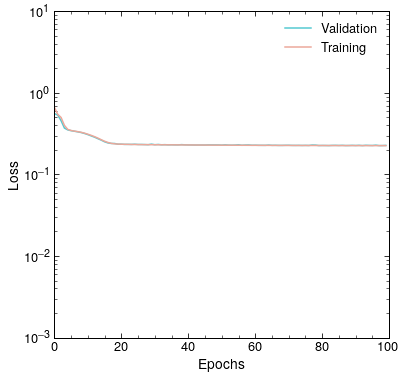

In [35]:
fig = plt.figure(figsize=(6,6))
plt.plot(history.history['val_loss'], label="Validation")
plt.plot(history.history['loss'], label="Training")
plt.yscale('log')
plt.ylim(.001,10)
plt.yticks(fontsize=13)
plt.xlim(0,nepochs)
plt.xticks(fontsize=13)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', ncol=1)
# plt.text(1000, 1.5, 'LR=1e-3', fontsize=13)
# plt.text(1000, 1, 'Batch: 3000', fontsize=13)
# plt.tight_layout()
plt.savefig(plotpath+'loss.pdf')
plt.show()

In [46]:
# get overall performance metric
# performance = model.evaluate(
#     X[test], Y[test],
#     verbose = 0,
# )

# get network scores for the dataset
preds = np.exp(regressor.predict(X[test])*Y_std+Y_mean)

150000/150000 [==============================] - 1s 4us/sample


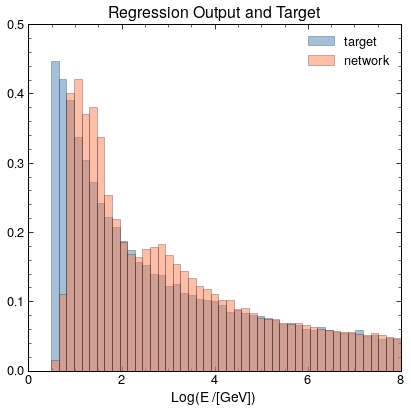

In [47]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(0,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(np.exp(Y[test]*Y_std+Y_mean), color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
plt.hist(preds, color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Dead Cell Energy /[GeV])', fontsize=14)
plt.xlim(0,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend()
# plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(plotpath+'predictions.pdf')
plt.show()

<Figure size 576x432 with 0 Axes>

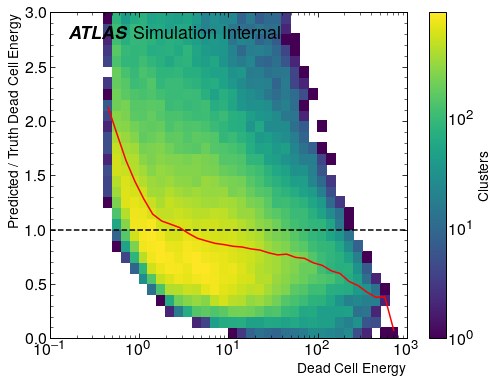

In [49]:
resplot = ru.responsePlot(x=np.exp(Y[test]*Y_std+Y_mean), y=preds/np.exp(Y[test]*Y_std+Y_mean),
                figfile=plotpath+'response.pdf',
                statistic='median', xlabel='Dead Cell Energy', ylabel='Predicted / Truth Dead Cell Energy',
                atlas_x=.05, atlas_y=.96, simulation=True,
                textlist=[])

## Variable Correlation

In [7]:
with ur.open(inputpath+'pi0-graph.root') as ifile:
    print(ifile['EventTree'].keys())

['runNumber', 'eventNumber', 'lumiBlock', 'coreFlags', 'mcEventNumber', 'mcChannelNumber', 'mcEventWeight', 'nTruthPart', 'G4PreCalo_n_EM', 'G4PreCalo_E_EM', 'G4PreCalo_n_Had', 'G4PreCalo_E_Had', 'truthVertexX', 'truthVertexY', 'truthVertexZ', 'truthPartPdgId', 'truthPartStatus', 'truthPartBarcode', 'truthPartPt', 'truthPartE', 'truthPartMass', 'truthPartEta', 'truthPartPhi', 'nTrack', 'trackPt', 'trackP', 'trackMass', 'trackEta', 'trackPhi', 'trackNumberOfPixelHits', 'trackNumberOfSCTHits', 'trackNumberOfPixelDeadSensors', 'trackNumberOfSCTDeadSensors', 'trackNumberOfPixelSharedHits', 'trackNumberOfSCTSharedHits', 'trackNumberOfPixelHoles', 'trackNumberOfSCTHoles', 'trackNumberOfInnermostPixelLayerHits', 'trackNumberOfNextToInnermostPixelLayerHits', 'trackExpectInnermostPixelLayerHit', 'trackExpectNextToInnermostPixelLayerHit', 'trackNumberOfTRTHits', 'trackNumberOfTRTOutliers', 'trackChiSquared', 'trackNumberDOF', 'trackD0', 'trackZ0', 'trackEta_PreSamplerB', 'trackPhi_PreSamplerB', 

In [ ]:
# with ur.open(inputpath+'pi-graph.root') as ifile:
with ur.open(inputpath+'pi0-graph.root') as ifile:
    pdata = ifile['EventTree'].arrays(cluster_branches)

## Energy Values that are not zero!
sel = (pdata['cluster_E'] != 0) & (pdata['cluster_ENG_CALIB_DEAD_TOT'] > 0.5)

df = pd.Dataframe([
    ak.to_numpy(ak.flatten(pdata[branch][sel]))[:n_max]
    for branch in pdata
], columns=[branch for branch in pdata])


In [ ]:
df.corr()